# Simple prediction of XTB stock price using LR and DTR

With more than 15 years experience, <a href="https://www.xtb.com/int"><b>XTB</b></a> is one of the largest stock exchange-listed FX & CFD brokers in the world. It has offices in over 13 countries including UK, Poland, Germany, France and Chile. 

According to the company <a href="https://ir.xtb.com/en/reports/https://ir.xtb.com/en/reports/">financial reports</a>, its main profits come from FX, comodities, and CFD contracts. So, the more volatility on the global financial market, the better for the profits. Keeping that in mind, I choose some key fundamental indicators (indices) or possible underlying products (USD/EUR, gold, oil). That seems to be the most promising for my analysis. What is essential due to the different timezones is that some of them can be treated as leading indicators, which is beneficial for the practical application of such research.

The datasets I have used are listed below:

- <a href="https://stooq.pl/q/?s=xtb&c=mx&t=l&a=ln&b=0https://stooq.pl/q/?s=xtb&c=mx&t=l&a=ln&b=0">X-Trade Brokers SA (XTB)</a>
- <a href="https://stooq.pl/q/?s=wighttps://stooq.pl/q/?s=wig">WIG (WIG)</a>
- <a href="https://stooq.pl/q/?s=^spxhttps://stooq.pl/q/?s=^spx">S&P 500 U.S. (^SPX)</a>
- <a href="https://finance.yahoo.com/quote/%5EVIX?p=%5EVIXhttps://finance.yahoo.com/quote/%5EVIX?p=%5EVIX">CBOE Volatility Index (^VIX)CBOE Volatility Index (^VIX)</a>
- <a href="https://stooq.pl/q/?s=usdeurhttps://stooq.pl/q/?s=usdeur">U.S. Dollar / Euro 1:1 (USDEUR)</a>
- <a href="https://stooq.pl/q/?s=gc.fhttps://stooq.pl/q/?s=gc.f">Gold - COMEX (GC.F)</a>
- <a href="https://stooq.pl/q/?s=cl.fhttps://stooq.pl/q/?s=cl.f">Crude Oil WTI - NYMEX (CL.F)</a>

In [940]:
# Importing key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import  mean_squared_error, r2_score

## Data and quick exploration

In [941]:
# Downloading data and checking datasets shape
for dset, file in zip(["xtb", "wig", "spx", "gld", "oil", "usd", "vix"],
                           ["xtb_d.csv", "wig_d.csv", "spx_d.csv","gc_f_d.csv",
                            "cl_f_d.csv", "usdeur_d.csv", "^VIX.csv"]):
    name = dset
    if file == "^VIX.csv":
        dset = pd.read_csv("Data/"+file, index_col="Date", parse_dates=True)
    else:
        dset = pd.read_csv("Data/"+file, index_col="Data", parse_dates=True)
    print(name, dset.shape, sep="\t")

xtb	(1092, 5)
wig	(6924, 5)
spx	(38293, 5)
gld	(12938, 6)
oil	(9917, 6)
usd	(12729, 4)
vix	(1259, 6)


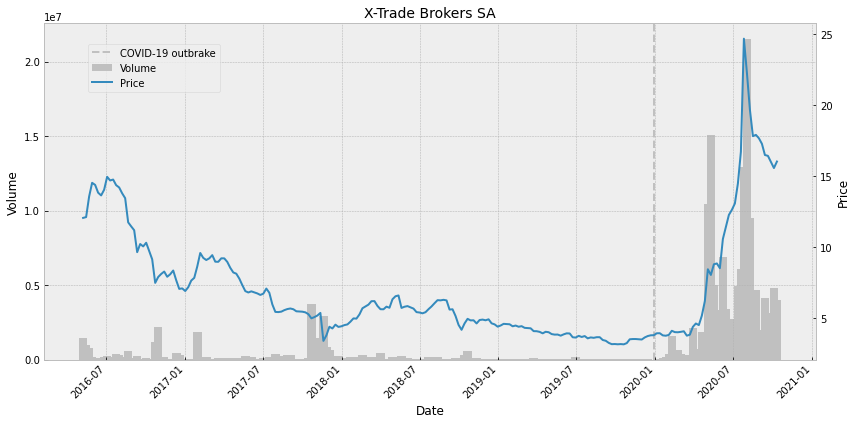

In [942]:
# Plotting the closing price and volume, weekly view
price = xtb.Zamkniecie.resample("W").mean()
volume = xtb.Wolumen.resample("W").sum()

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.bar(volume.index, volume, color="silver", width=20)
ax.set(xlabel="Date", ylabel="Volume", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)
ax.axvline("2019-12-30", color="silver", linestyle="--", linewidth=2)

ax2 = ax.twinx()
ax2.plot(price.index, price, linewidth=2)
ax2.set(ylabel="Price", yscale="linear")

fig.legend(["COVID-19 outbrake", "Volume", "Price"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.grid()
plt.tight_layout()
plt.show()

<b>Covid-19</b>
<br>A quick look at the chart illustrates how significantly the COVID-19 outbreak has impacted the stock quotations. It is the uncertainty and market volatility caused by COVID-19 that contributed to the unprecedented profit growth in the first quarter of 2020, and as a result, the stock price growth.
<p><b>Volume and price movements</b>
<br>Research on the company also indicates that unprecedented trade volume levels are directly related to the new investors. The majority of them are private individuals with small capital. That could result in above the average price volatility since institutional investors' power is limited and cannot effectively stabilize the price movements. It affects the Machine Learning predictions' credibility as the models do not include human psychological and behavioral factors.

In [943]:
# constructing dataset
dataset = pd.concat([xtb["Zamkniecie"], 
                     wig["Zamkniecie"], 
                     spx["Zamkniecie"], 
                     gld["Zamkniecie"], 
                     oil["Zamkniecie"], 
                     usd["Zamkniecie"], 
                     vix["Close"]], axis=1).dropna()

dataset.columns = ["xtb", "wig", "spx", "gld", "oil", "usd", "vix"]
dataset.shape

(1062, 7)

In [944]:
#Saving the most recent features
tommorow = dataset.iloc[-1][1:]
tommorow

wig    49727.340000
spx     3446.830000
gld     1895.100000
oil       41.190000
usd        0.850380
vix       26.360001
Name: 2020-10-08 00:00:00, dtype: float64

In [945]:
# Important! Shifting the XTB foreward.Features areused to predict the next day of XTB stock value! 
dataset["xtb"] = dataset["xtb"].shift(1)
dataset.dropna(inplace=True)
dataset.head()

,xtb,wig,spx,gld,oil,usd,vix
2016-05-09,12.05066,46628.94,2058.69,1265.00,43.27,0.87860,14.57
2016-05-10,12.00021,46178.72,2084.39,1267.45,44.52,0.87946,13.63
2016-05-11,11.94016,46053.07,2064.46,1278.80,45.99,0.87524,14.69
2016-05-12,12.05066,46022.02,2064.11,1264.75,46.44,0.87911,14.41
2016-05-13,12.15035,46063.67,2046.61,1274.60,46.38,0.88403,15.04


In [946]:
# Correlation between the variables
cor = dataset.corr()
cor

,xtb,wig,spx,gld,oil,usd,vix
xtb,1.000000,-0.539323,-0.083442,0.442220,-0.438933,0.009663,0.133021
wig,-0.539323,1.000000,0.194725,-0.382550,0.621900,-0.452105,-0.569016
spx,-0.083442,0.194725,1.000000,0.682094,0.105770,-0.243716,0.223788
gld,0.442220,-0.382550,0.682094,1.000000,-0.536976,-0.045489,0.564971
oil,-0.438933,0.621900,0.105770,-0.536976,1.000000,-0.376914,-0.573584
usd,0.009663,-0.452105,-0.243716,-0.045489,-0.376914,1.000000,0.067308
vix,0.133021,-0.569016,0.223788,0.564971,-0.573584,0.067308,1.000000


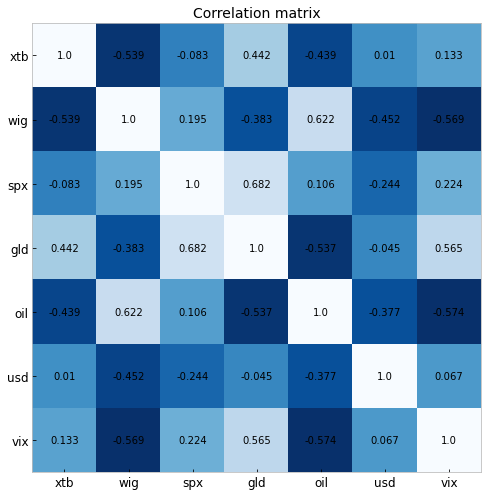

In [947]:
fig,ax =plt.subplots(figsize=(7,7))

ax.imshow(cor, cmap="Blues_r")
ax.set_title("Correlation matrix", fontsize=14)
ax.set_xticks(np.arange(len(cor.columns)))
ax.set_xticklabels(cor.columns, fontsize=12)
ax.set_yticks(np.arange(len(cor.index.values)))
ax.set_yticklabels(cor.index.values, fontsize=12)

for i in range(len(cor.index.values)):
    for c in range(len(cor.columns.values)):
        text = ax.text(i, c, cor.iloc[i,c].round(3), 
                       ha="center", va="center", color="black")

plt.grid(False)
plt.tight_layout()
plt.show()

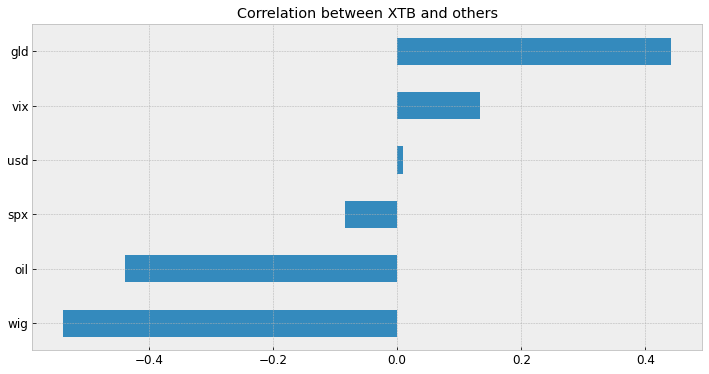

In [948]:
cor.xtb.sort_values(ascending=True)[:-1].plot(kind="barh",
                                         figsize=(12,6),
                                         title="Correlation between XTB and others",
                                         fontsize=12)
plt.show()

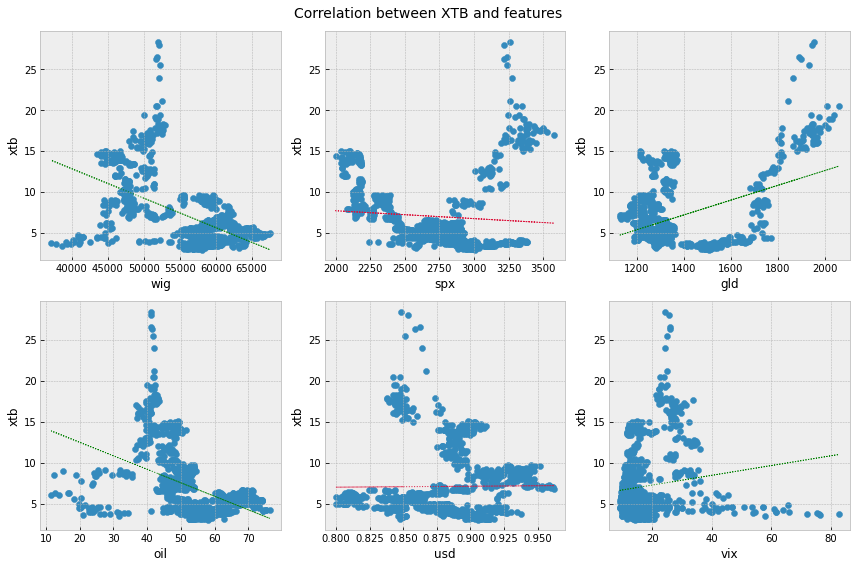

In [949]:
lr=LinearRegression()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
fig.suptitle("Correlation between XTB and features", fontsize=14)

for ax, col in zip(ax.flatten(), dataset.columns[1:]):
    ax.scatter(dataset[col].values, dataset["xtb"].values)
    ax.set(xlabel=col, ylabel="xtb")
    
    lr.fit(dataset[col].values.reshape(-1,1), dataset["xtb"].values.reshape(-1,1))
    predictions = lr.predict(dataset[col].values.reshape(-1,1))
    
    if col == "spx" or col == "usd":
        c = "crimson"
    else:
        c= "green"
        
    ax.plot(dataset[col].values, predictions, color=c, linestyle=":", linewidth=1)

plt.tight_layout()
plt.show()

## Models training

In [950]:
# Chosing features and labels
labels = dataset["xtb"].values
features = dataset.drop("xtb", axis=1).values

In [951]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Linear Regression

In [952]:
# Applying Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [953]:
# Measuring LR results
print("LR results:")
print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
lr_r2 = r2_score(y_test, predictions)
print('R2: %.4f' % r2_score(y_test, predictions))

LR results:
MSE: 4.9763
RMSE: 2.2308
R2: 0.6350


In [954]:
# Features importance
pd.Series(index=dataset.drop("xtb", axis=1).columns, 
          data=lr.coef_,name="Coef").sort_values()

usd   -30.457744
vix    -0.234429
spx    -0.007356
wig    -0.000325
gld     0.021101
oil     0.030790
Name: Coef, dtype: float64

In [955]:
# Grid search
param = {"fit_intercept":[True, False], "normalize":[True, False]}

gs_lr = GridSearchCV(lr, param)
gs_lr.fit(X_train, y_train)
print("Best params:", gs_lr.best_params_)
print("Best score:", gs_lr.best_score_)

Best params: {'fit_intercept': True, 'normalize': False}
Best score: 0.6366415670239981


### DecisionTree Regressor

In [956]:
# Applying DTR results
dtr = DecisionTreeRegressor(max_features="auto")
dtr.fit(X_train, y_train)
predictions = dtr.predict(X_test)

In [957]:
# Measuring DTR results
print("DTR results:")
print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
dtr_r2 = r2_score(y_test, predictions)
print('R2: %.4f' % r2_score(y_test, predictions))

DTR results:
MSE: 0.4789
RMSE: 0.6920
R2: 0.9649


In [958]:
# Features importance
pd.Series(index=dataset.drop("xtb", axis=1).columns, 
          data=dtr.feature_importances_ ,name="Coef").sort_values()

oil    0.010906
vix    0.013414
usd    0.016555
wig    0.080822
spx    0.294576
gld    0.583728
Name: Coef, dtype: float64

In [959]:
# Grid search
param = {"max_features":["auto", "sqrt", "log2"]}

gs_dtr = GridSearchCV(dtr, param)
gs_dtr.fit(X_train, y_train)
print("Best params:", gs_dtr.best_params_)
print("Best score:", gs_dtr.best_score_)

Best params: {'max_features': 'auto'}
Best score: 0.9462724651645449


## Results

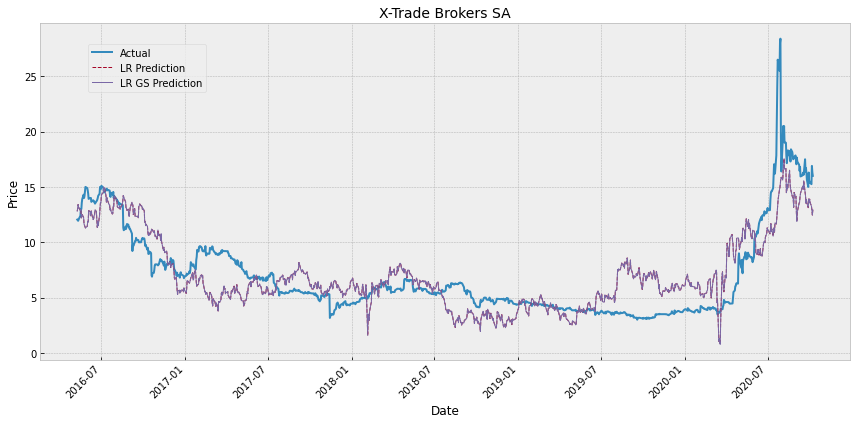

In [960]:
# Plotting LR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, 
        pd.Series(lr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="--")

ax.plot(dataset.index, 
        pd.Series(gs_lr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="-")

fig.legend(["Actual", "LR Prediction", "LR GS Prediction"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

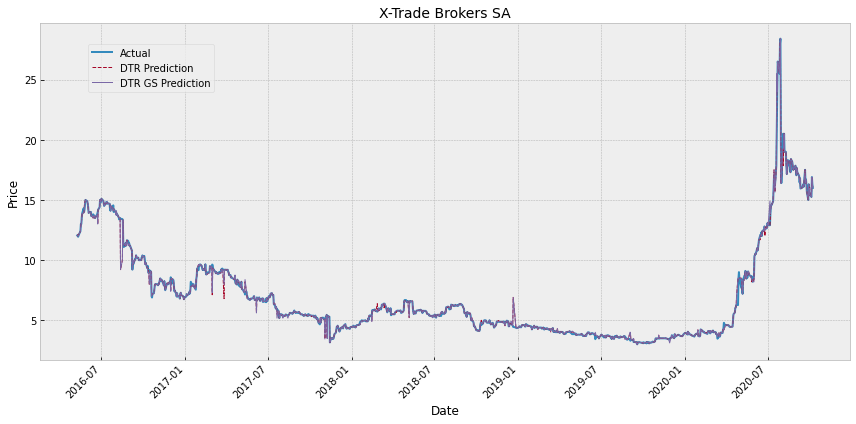

In [961]:
# Plotting DTR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, 
        pd.Series(dtr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="--")

ax.plot(dataset.index, 
        pd.Series(gs_dtr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="-")

fig.legend(["Actual", "DTR Prediction", "DTR GS Prediction"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

## Next day price prediction

In [965]:
lr_price = lr.predict(tommorow.values.reshape(1,-1))
dtr_price = dtr.predict(tommorow.values.reshape(1,-1))

print("LR prediction for tommorow:", "\t", lr_price)
print("DTR Prediction for tommorow:","\t", dtr_price)

LR prediction for tommorow: 	 [12.92548167]
DTR Prediction for tommorow: 	 [16.]


In [966]:
# Weighted average of price prediction
weighted_price = ((lr_r2 * lr_price) + (dtr_r2 * dtr_price))/2
print(weighted_price.round(2))

[11.82]
